In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df.shape

(1338, 7)

In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

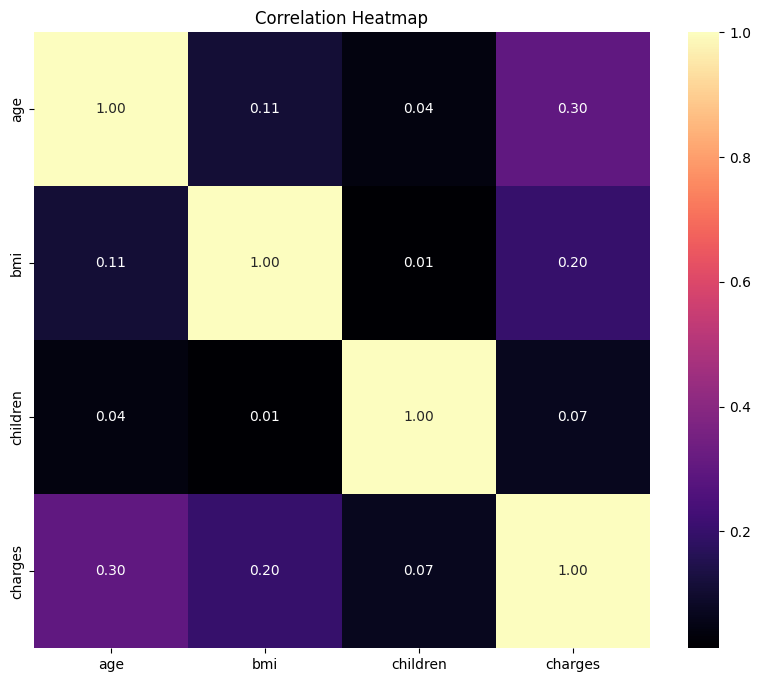

In [5]:
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='magma', square=True)
plt.title('Correlation Heatmap')
plt.show()


# Data Splitting

In [6]:
def train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True):
    if len(arrays) == 0:
        raise ValueError("At least one array required.")

    n_samples = len(arrays[0])
    for arr in arrays:
        if len(arr) != n_samples:
            raise ValueError("All input arrays must have the same length.")

    if isinstance(random_state, int):
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random if random_state is None else random_state

    if test_size is None and train_size is None:
        test_size = 0.25

    if test_size is not None:
        if isinstance(test_size, float):
            n_test = int(np.ceil(test_size * n_samples))
        else:
            n_test = int(test_size)
    else:
        n_test = n_samples - int(train_size)

    n_train = n_samples - n_test

    if shuffle:
        indices = rng.permutation(n_samples)
    else:
        indices = np.arange(n_samples)

    train_indices = indices[:n_train]
    test_indices = indices[n_train:]

    result = []
    for arr in arrays:
        result.append(np.array(arr)[train_indices])
        result.append(np.array(arr)[test_indices])

    return result

In [7]:
X = df.drop("charges", axis = 1)
Y = df["charges"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(Y_train.shape)

(1070, 6)
(268, 6)
(268,)
(1070,)


# Linear Regression

In [9]:
def compute_cost_linear(X, y, w, b, lambda_=1):
    m = X.shape[0]
    cost = 0 
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b
        cost += (f_wb_i - y[i])**2
    cost /= (2 * m)

    # Regularization term
    reg_cost = (lambda_ / (2 * m)) * np.sum(w**2)
    total_cost = cost + reg_cost
    return total_cost

In [10]:
def compute_gradient_linear_reg(X, y, w, b, lambda_):
    m, n = X.shape           
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]                 
        for j in range(n):                         
            dj_dw[j] += err * X[i, j]               
        dj_db += err                        
    dj_dw /= m                                
    dj_db /= m   
    
    # Regularization term
    dj_dw += (lambda_ / m) * w

    return dj_dw, dj_db

In [11]:

def gradient_descent(x, y, w_init, b_init, learning_rate, iterations, lambda_=1):
    w = w_init
    b = b_init
    for i in range(iterations):
        dj_dw, dj_db = compute_gradient_linear_reg(x, y, w, b, lambda_)

        # Update parameters
        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db

        if i % 100 == 0 or i == iterations - 1:
            cost = compute_cost_linear(x, y, w, b, lambda_)
            w_str = ", ".join([f"{wi:.4f}" for wi in w])
            print(f"Iteration {i+1}: Cost = {cost:.4f}, w = [{w_str}], b = {b:.4f}")
        
    return w, b

In [12]:
X_columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
X_train_df = pd.DataFrame(X_train, columns=X_columns)
X_train_encoded = pd.get_dummies(X_train_df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Convert to float for normalization
X_train_encoded = X_train_encoded.astype(float)

# Normalize data
X_mean = X_train_encoded.mean(axis=0)
X_std = X_train_encoded.std(axis=0)
X_train_norm = (X_train_encoded - X_mean) / X_std

w_init = np.zeros(X_train_norm.shape[1])
b_init = 0
learning_rate = 0.01  
iterations = 5000
w, b = gradient_descent(X_train_norm.values, Y_train, w_init, b_init, learning_rate, iterations)

Iteration 1: Cost = 157859174.8582, w = [35.6385, 23.4126, 7.2086, 8.2793, 94.2672, -3.1276, 8.2637, -4.3743], b = 133.1471
Iteration 101: Cost = 36974797.0130, w = [2295.0996, 1328.7436, 429.5666, 292.6543, 6017.2578, -58.3165, 163.3471, -180.4410], b = 8489.8333
Iteration 201: Cost = 20681210.3586, w = [3142.0329, 1723.9006, 548.3089, 202.6494, 8218.3167, -13.1524, -44.9378, -205.0639], b = 11548.6508
Iteration 301: Cost = 18420804.4546, w = [3458.2181, 1866.8636, 574.9194, 101.5090, 9049.7763, -5.8445, -211.1154, -229.3863], b = 12668.2769
Iteration 401: Cost = 18096799.6474, w = [3575.2301, 1927.9012, 577.8822, 39.4980, 9367.8926, -22.8542, -314.7942, -260.2906], b = 13078.0962
Iteration 501: Cost = 18046774.4321, w = [3617.9402, 1957.4786, 576.4708, 7.3782, 9490.9429, -46.8295, -378.8556, -290.6213], b = 13228.1034
Iteration 601: Cost = 18037378.3245, w = [3633.2062, 1973.1785, 575.1167, -7.9872, 9539.0540, -69.6738, -420.1691, -316.5858], b = 13283.0108
Iteration 701: Cost = 1803

# Predicted vs Actual

In [13]:
# Predict function
def predict(X, w, b):
    return np.dot(X, w) + b

# Predict on train data
Y_pred = predict(X_train_norm, w, b)

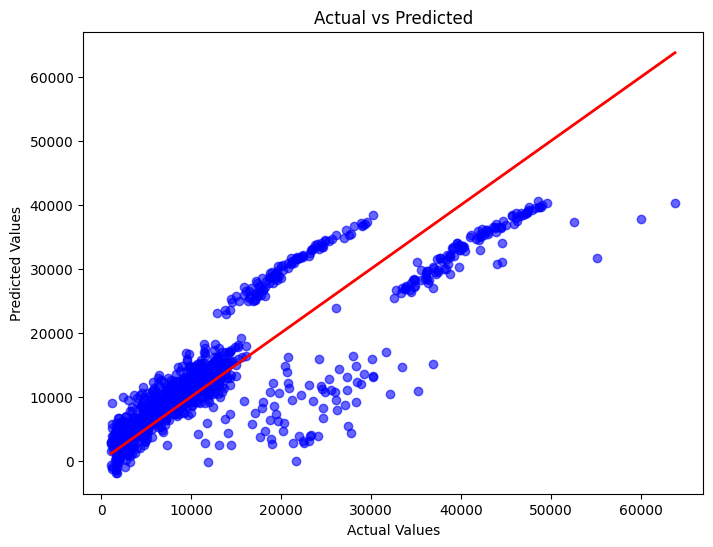

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_train, Y_pred, color='blue', alpha=0.6)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color='red', linewidth=2)  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

# Logistic Regression

In [15]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [16]:
def compute_cost_logistic_reg(X, y, w, b, lambda_ = 1):
    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      
        f_wb_i = sigmoid(z_i)                                          
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      
             
    cost = cost/m                                                      
    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)                                          
    reg_cost = (lambda_/(2*m)) * reg_cost                              
    
    total_cost = cost + reg_cost                                       
    return total_cost

In [17]:
def compute_gradient_logistic_reg(X, y, w, b, lambda_): 
    m,n = X.shape
    dj_dw = np.zeros((n,))                            
    dj_db = 0.0                                      

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          
        err_i  = f_wb_i  - y[i]                      
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   

    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw 

In [18]:
def gradient_descent_log(x, y, w_init, b_init, learning_rate, iterations, lambda_=1):
    w = w_init
    b = b_init
    for i in range(iterations):
        dj_db, dj_dw = compute_gradient_logistic_reg(x, y, w, b, lambda_)

        # Update parameters
        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db

        if i % 100 == 0 or i == iterations - 1:
            cost = compute_cost_logistic_reg(x, y, w, b, lambda_)
            w_flat = w.flatten()
            w_str = ", ".join([f"{float(wi):.4f}" for wi in w_flat])
            print(f"Iteration {i+1}: Cost = {cost:.4f}, w = [{w_str}], b = {b:.4f}")

    return w, b

In [19]:
# Binary target: 1 if charges > median, else 0
df['target'] = (df['charges'] > df['charges'].median()).astype(int)

# Drop the original target column (regression value)
X_log = df.drop(['charges', 'target'], axis=1)
X_log = pd.get_dummies(X_log, columns=['sex', 'smoker', 'region'], drop_first=True).astype(float).values
Y_log = df['target'].values

# Split for logistic regression
X_train_log, X_test_log, Y_train_log, Y_test_log = train_test_split(X_log, Y_log, test_size=0.2, random_state=42)

# Normalisation for logistic regression
X_mean_log = np.mean(X_train_log, axis=0)
X_std_log = np.std(X_train_log, axis=0)
X_train_log_norm = (X_train_log - X_mean_log) / X_std_log

# Initialize
w_init = np.zeros(X_train_log_norm.shape[1])
b_init = 0.0
learning_rate = 0.02  
iterations = 10000

# Train logistic regression
w, b = gradient_descent_log(X_train_log_norm, Y_train_log, w_init, b_init, learning_rate, iterations)

Iteration 1: Cost = 0.6905, w = [0.0051, 0.0009, 0.0003, -0.0002, 0.0051, -0.0002, -0.0001, -0.0001], b = 0.0001
Iteration 101: Cost = 0.5223, w = [0.4076, 0.0608, 0.0218, -0.0250, 0.4101, -0.0158, -0.0150, -0.0075], b = 0.0083
Iteration 201: Cost = 0.4478, w = [0.6728, 0.0888, 0.0319, -0.0474, 0.6848, -0.0246, -0.0361, -0.0158], b = 0.0181
Iteration 301: Cost = 0.4072, w = [0.8644, 0.1042, 0.0378, -0.0665, 0.8915, -0.0314, -0.0566, -0.0252], b = 0.0303
Iteration 401: Cost = 0.3819, w = [1.0122, 0.1139, 0.0422, -0.0828, 1.0576, -0.0374, -0.0752, -0.0351], b = 0.0440
Iteration 501: Cost = 0.3647, w = [1.1311, 0.1206, 0.0463, -0.0968, 1.1966, -0.0431, -0.0920, -0.0452], b = 0.0580
Iteration 601: Cost = 0.3523, w = [1.2299, 0.1256, 0.0505, -0.1089, 1.3162, -0.0486, -0.1072, -0.0551], b = 0.0717
Iteration 701: Cost = 0.3429, w = [1.3137, 0.1295, 0.0548, -0.1195, 1.4211, -0.0541, -0.1210, -0.0648], b = 0.0851
Iteration 801: Cost = 0.3357, w = [1.3861, 0.1327, 0.0592, -0.1289, 1.5144, -0.059

In [20]:
def predict_logistic(X, w, b):
    probs = sigmoid(np.dot(X, w) + b)
    return (probs >= 0.5).astype(int)

# Normalize test data using train mean/std
X_train_log_norm = (X_train_log - X_mean_log) / X_std_log

# Predict on test set
Y_pred_log = predict_logistic(X_train_log_norm, w, b)

# Accuracy
accuracy = np.mean(Y_pred_log == Y_train_log)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9131


# Problem 

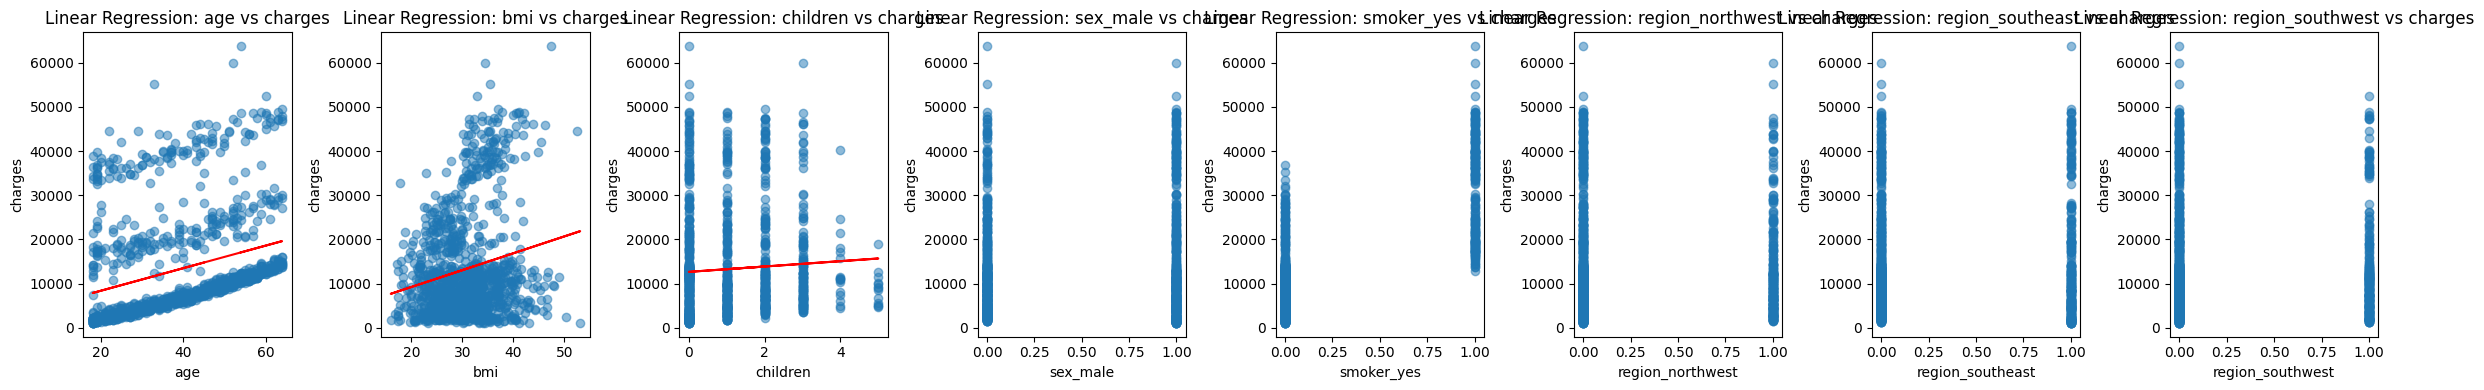

In [30]:
features = X_train_encoded.columns
fig, axes = plt.subplots(1, len(features), figsize=(24, 4))
for idx, feature in enumerate(features):
    axes[idx].scatter(X_train_encoded[feature], Y_train, alpha=0.5)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('charges')
    axes[idx].set_title(f'Linear Regression: {feature} vs charges')

    # Add regression line for numeric features
    if X_train_encoded[feature].nunique() > 2:
        x = X_train_encoded[feature]
        y = Y_train
        coeffs = np.polyfit(x, y, 1)
        y_fit = np.polyval(coeffs, x)
        axes[idx].plot(x, y_fit, color='red')

    plt.tight_layout()
